In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler, RobustScaler

In [27]:
def load_and_inspect_data():
    # Load the data
    df = pd.read_csv('uk_renewable_energy.csv')
    
    # Display basic information about the dataset
    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    return df

In [37]:
def exploratory_analysis(df):
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create a figure for overall renewable energy trend
    plt.figure(figsize=(12, 6))
    plt.plot(df['Year'], df['Fraction from renewable sources and waste'], marker='o', linewidth=2)
    plt.title('Percentage of UK Energy from Renewable Sources (1990-2020)')
    plt.xlabel('Year')
    plt.ylabel('Fraction from Renewable Sources')
    plt.grid(True)
    plt.savefig('renewable_trend.png')
    plt.close()
    
    # Create a stacked area chart for the composition of renewable energy
    renewable_sources = ['Hydroelectric power', 'Wind, wave, tidal', 'Solar photovoltaic', 
                         'Landfill gas', 'Municipal solid waste (MSW)', 'Biomass',
                         'Wood', 'Liquid bio-fuels']
    
    plt.figure(figsize=(14, 8))
    plt.stackplot(df['Year'], [df[source] for source in renewable_sources], 
                 labels=renewable_sources, alpha=0.8)
    plt.title('Composition of UK Renewable Energy Sources (1990-2020)')
    plt.xlabel('Year')
    plt.ylabel('Energy (units)')
    plt.legend(loc='upper left')
    plt.show()
    
    # Calculate and plot growth rates for key renewable sources
    recent_years = df[df['Year'] >= 2010].copy()
    growth_sources = ['Wind, wave, tidal', 'Solar photovoltaic', 'Biomass']
    
    plt.figure(figsize=(12, 6))
    for source in growth_sources:
        plt.plot(recent_years['Year'], recent_years[source], marker='o', label=source)
    
    plt.title('Growth of Selected UK Renewable Energy Sources (2010-2020)')
    plt.xlabel('Year')
    plt.ylabel('Energy Production')
    plt.legend()
    plt.show()
    
    # Correlation analysis
    correlation = df.corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of UK Energy Variables')
    plt.tight_layout()
    plt.show()
    
    # Calculate year-over-year percentage change for total renewables
    df['YoY_Change'] = df['Energy from renewable & waste sources'].pct_change() * 100
    
    plt.figure(figsize=(12, 6))
    plt.bar(df['Year'][1:], df['YoY_Change'][1:], color='green')
    plt.axhline(y=0, color='red', linestyle='-')
    plt.title('Year-over-Year Percentage Change in Renewable Energy Production')
    plt.xlabel('Year')
    plt.ylabel('Percentage Change (%)')
    plt.grid(True, axis='y')
    plt.show()
    
    return df

In [38]:
def build_prediction_models(features_df):
    # Define target variables and prediction horizons
    target_variables = [
        'Energy from renewable & waste sources',
        'Fraction from renewable sources and waste',
        'Wind, wave, tidal',
        'Solar photovoltaic'
    ]
    
    # Store model results
    model_results = {}
    
    for target in target_variables:
        print(f"\n--- Building prediction models for {target} ---")
        
        # Select features (excluding the target and some metadata columns)
        exclude_cols = target_variables + ['Year', 'YoY_Change']
        X = features_df.drop(columns=exclude_cols)
        y = features_df[target]
        
        # Check for and handle any remaining problematic values
        # Replace any remaining inf values with NaN
        X = X.replace([np.inf, -np.inf], np.nan)
        # Fill NaN values with column means
        X = X.fillna(X.mean())
        
        # Print min and max values to check for extremely large values
        print("Feature ranges:")
        print(X.describe().loc[['min', 'max']].T)
        
        # Split data (using time-based split since this is time series data)
        train_size = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
        
        # Use RobustScaler which is less affected by outliers
        scaler = RobustScaler()
        try:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        except Exception as e:
            print(f"Scaling error: {e}")
            # Fallback to manual scaling if RobustScaler fails
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            for col in X_train.columns:
                median = X_train[col].median()
                iqr = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
                if iqr > 0:  # Avoid division by zero
                    X_train_scaled[col] = (X_train[col] - median) / iqr
                    X_test_scaled[col] = (X_test[col] - median) / iqr
        
        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)
        lr_pred = lr_model.predict(X_test_scaled)
        lr_mse = mean_squared_error(y_test, lr_pred)
        lr_r2 = r2_score(y_test, lr_pred)
        
        # Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        rf_pred = rf_model.predict(X_test_scaled)
        rf_mse = mean_squared_error(y_test, rf_pred)
        rf_r2 = r2_score(y_test, rf_pred)
        
        # Store results
        model_results[target] = {
            'Linear Regression': {'MSE': lr_mse, 'R²': lr_r2, 'model': lr_model},
            'Random Forest': {'MSE': rf_mse, 'R²': rf_r2, 'model': rf_model}
        }
        
        # Print results
        print(f"Linear Regression - MSE: {lr_mse:.4f}, R²: {lr_r2:.4f}")
        print(f"Random Forest - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")
        
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.plot(features_df['Year'].iloc[train_size:], y_test, 'b-', label='Actual')
        plt.plot(features_df['Year'].iloc[train_size:], lr_pred, 'r--', label='Linear Regression')
        plt.plot(features_df['Year'].iloc[train_size:], rf_pred, 'g--', label='Random Forest')
        plt.title(f'Actual vs Predicted {target}')
        plt.xlabel('Year')
        plt.ylabel(target)
        plt.legend()
        plt.savefig(f'prediction_{target.replace(" ", "_").replace(",", "")}.png')
        plt.close()
    
    return model_results

In [39]:
def prepare_features(df):
    # Create lagged features
    features_df = df.copy()
    
    # Add time-based features
    features_df['Years_Since_1990'] = features_df['Year'] - 1990
    features_df['Decade'] = (features_df['Year'] // 10) * 10
    
    # Create lagged variables for the main renewable energy metrics
    for lag in range(1, 4):
        features_df[f'Total_Renewable_Lag_{lag}'] = features_df['Energy from renewable & waste sources'].shift(lag)
        features_df[f'Fraction_Renewable_Lag_{lag}'] = features_df['Fraction from renewable sources and waste'].shift(lag)
    
    # Add rolling means
    features_df['Renewable_3yr_Rolling_Mean'] = features_df['Energy from renewable & waste sources'].rolling(window=3).mean()
    features_df['Fraction_3yr_Rolling_Mean'] = features_df['Fraction from renewable sources and waste'].rolling(window=3).mean()
    
    # Calculate growth rates for key sources, ensuring no infinity values
    for source in ['Wind, wave, tidal', 'Solar photovoltaic', 'Biomass', 'Wood']:
        # Replace zeros with a small value to avoid division by zero when calculating growth rates
        features_df[source] = features_df[source].replace(0, 0.0001)
        # Calculate growth rate
        features_df[f'{source}_Growth'] = features_df[source].pct_change()
        # Replace inf values with a large but finite number
        features_df[f'{source}_Growth'] = features_df[f'{source}_Growth'].replace([np.inf, -np.inf], np.nan)
        # Fill NaN values with the mean
        features_df[f'{source}_Growth'] = features_df[f'{source}_Growth'].fillna(features_df[f'{source}_Growth'].mean())
    
    # Drop rows with NaN values resulting from lagging/rolling operations
    features_df = features_df.dropna()
    
    # Check for any remaining infinity values in the dataframe
    for column in features_df.columns:
        if features_df[column].isin([np.inf, -np.inf]).any():
            print(f"Infinity values found in column {column}")
            # Replace infinity with NaNs and then fill with column mean
            features_df[column] = features_df[column].replace([np.inf, -np.inf], np.nan)
            features_df[column] = features_df[column].fillna(features_df[column].mean())
    
    print(f"Shape after feature engineering: {features_df.shape}")
    return features_df

In [45]:
def time_series_forecasting(df):
    # Focus on total renewable energy and fraction
    targets = ['Energy from renewable & waste sources', 'Fraction from renewable sources and waste']
    forecast_results = {}
    
    for target in targets:
        # Prepare the time series
        ts_data = df.set_index('Year')[target]
        
        # Fit ARIMA model (p,d,q parameters should be tuned)
        model = ARIMA(ts_data, order=(1, 1, 1))
        model_fit = model.fit()
        
        # Summary
        print(f"\nARIMA Model Summary for {target}:")
        print(model_fit.summary())
        
        # Forecast 5 years ahead
        forecast_obj = model_fit.get_forecast(steps=5)
        forecast_mean = forecast_obj.predicted_mean
        forecast_ci = forecast_obj.conf_int()

        forecast_years = range(df['Year'].max() + 1, df['Year'].max() + 6)
        
        # Plot historical data and forecast
        plt.figure(figsize=(12, 6))
        plt.plot(df['Year'], df[target], 'b-', label='Historical Data')
        plt.plot(forecast_years, forecast_mean, 'r--', label='ARIMA Forecast')
        plt.fill_between(forecast_years, 
                         forecast_ci.iloc[:, 0],  # Lower bound
                         forecast_ci.iloc[:, 1],  # Upper bound
                         color='pink', alpha=0.3)
        plt.title(f'ARIMA Forecast for {target} (5 Years)')
        plt.xlabel('Year')
        plt.ylabel(target)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Store results
        forecast_results[target] = {
            'model': model_fit,
            'forecast': forecast_mean,
            'forecast_years': forecast_years
        }
    
    return forecast_results

In [46]:
def analyze_feature_importance(model_results, features_df):
    # For each target variable and the Random Forest model
    for target, models in model_results.items():
        rf_model = models['Random Forest']['model']
        
        # Get feature importances
        feature_names = features_df.drop(columns=[target, 'Year', 'YoY_Change'] + 
                                        [t for t in model_results.keys() if t != target]).columns
        importances = rf_model.feature_importances_
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance for Predicting {target}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig(f'feature_importance_{target.replace(" ", "_").replace(",", "")}.png')
        plt.close()
        
        # Print top 10 important features
        print(f"\nTop 10 Important Features for {target}:")
        for i in range(min(10, len(feature_names))):
            print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [47]:
def model_future_scenarios(model_results, features_df):
    # Define scenarios
    scenarios = {
        'Conservative Growth': {
            'Wind, wave, tidal_Growth': 0.05,  # 5% annual growth
            'Solar photovoltaic_Growth': 0.08,  # 8% annual growth
            'Biomass_Growth': 0.03,            # 3% annual growth
            'Wood_Growth': 0.02                # 2% annual growth
        },
        'Aggressive Growth': {
            'Wind, wave, tidal_Growth': 0.15,  # 15% annual growth
            'Solar photovoltaic_Growth': 0.25,  # 25% annual growth
            'Biomass_Growth': 0.10,            # 10% annual growth
            'Wood_Growth': 0.08                # 8% annual growth
        },
        'Mixed Growth': {
            'Wind, wave, tidal_Growth': 0.12,  # 12% annual growth
            'Solar photovoltaic_Growth': 0.18,  # 18% annual growth
            'Biomass_Growth': 0.05,            # 5% annual growth
            'Wood_Growth': 0.03                # 3% annual growth
        }
    }
    
    # Get the latest data point as starting point
    latest_data = features_df.iloc[-1:].copy()
    forecast_years = range(int(latest_data['Year'].values[0]) + 1, int(latest_data['Year'].values[0]) + 11)
    
    # Target to predict
    target = 'Fraction from renewable sources and waste'
    
    # Get the model
    rf_model = model_results[target]['Random Forest']['model']
    
    # Store scenario results
    scenario_results = {scenario: [] for scenario in scenarios.keys()}
    
    # Create forecasts for each scenario
    for scenario_name, growth_rates in scenarios.items():
        # Start with the latest data
        current_data = latest_data.copy()
        scenario_forecast = []
        
        for year in forecast_years:
            # Update the year
            current_data['Year'] = year
            current_data['Years_Since_1990'] = year - 1990
            current_data['Decade'] = (year // 10) * 10
            
            # Apply growth rates according to scenario
            for source, growth_rate in growth_rates.items():
                base_source = source.replace('_Growth', '')
                current_data[base_source] = current_data[base_source] * (1 + growth_rate)
                current_data[source] = growth_rate
            
            # Update lagged variables
            if len(scenario_forecast) >= 1:
                current_data['Total_Renewable_Lag_1'] = current_data['Energy from renewable & waste sources']
                current_data['Fraction_Renewable_Lag_1'] = scenario_forecast[-1]
            
            if len(scenario_forecast) >= 3:
                current_data['Renewable_3yr_Rolling_Mean'] = np.mean(
                    [current_data['Energy from renewable & waste sources'].values[0]] + 
                    [current_data['Total_Renewable_Lag_1'].values[0]] + 
                    [current_data['Total_Renewable_Lag_2'].values[0]]
                )
                current_data['Fraction_3yr_Rolling_Mean'] = np.mean(
                    [scenario_forecast[-1]] + 
                    [scenario_forecast[-2]] + 
                    [scenario_forecast[-3]]
                )
            
            # Check for and handle any problematic values
            for col in current_data.columns:
                current_data[col] = current_data[col].replace([np.inf, -np.inf], np.nan)
                if current_data[col].isnull().any():
                    current_data[col] = current_data[col].fillna(features_df[col].mean())
            
            # Make prediction
            X = current_data.drop(columns=[target, 'Year', 'YoY_Change'] + 
                                [t for t in model_results.keys() if t != target])
            
            # Apply robust scaling
            scaler = RobustScaler()
            try:
                X_scaled = scaler.fit_transform(X)
            except Exception as e:
                print(f"Scaling error in scenario modeling: {e}")
                # Fallback to manual scaling
                X_scaled = X.copy()
                for col in X.columns:
                    median = features_df[col].median()
                    iqr = features_df[col].quantile(0.75) - features_df[col].quantile(0.25)
                    if iqr > 0:  # Avoid division by zero
                        X_scaled[col] = (X[col] - median) / iqr
            
            prediction = rf_model.predict(X_scaled)[0]
            scenario_forecast.append(prediction)
            
            # Update lagged variables for next iteration
            if len(scenario_forecast) >= 2:
                current_data['Total_Renewable_Lag_2'] = current_data['Total_Renewable_Lag_1']
                current_data['Fraction_Renewable_Lag_2'] = current_data['Fraction_Renewable_Lag_1']
            
            if len(scenario_forecast) >= 3:
                current_data['Total_Renewable_Lag_3'] = current_data['Total_Renewable_Lag_2']
                current_data['Fraction_Renewable_Lag_3'] = current_data['Fraction_Renewable_Lag_2']
        
        scenario_results[scenario_name] = scenario_forecast
    
    # Plot scenario forecasts
    plt.figure(figsize=(12, 8))
    
    # Plot historical data
    plt.plot(features_df['Year'], features_df[target], 'b-', label='Historical Data')
    
    # Plot each scenario
    colors = ['green', 'red', 'purple']
    for i, (scenario_name, forecast) in enumerate(scenario_results.items()):
        plt.plot(forecast_years, forecast, linestyle='--', color=colors[i], label=scenario_name)
    
    plt.title(f'UK Renewable Energy Fraction Scenarios (2021-2030)')
    plt.xlabel('Year')
    plt.ylabel('Fraction of Energy from Renewable Sources')
    plt.legend()
    plt.grid(True)
    plt.savefig('renewable_energy_scenarios.png')
    plt.close()
    
    return scenario_results

In [48]:
def main():
    # Load data
    print("Step 1: Loading and inspecting data...")
    df = load_and_inspect_data()
    
    # Exploratory analysis
    print("\nStep 2: Performing exploratory data analysis...")
    df = exploratory_analysis(df)
    
    # Feature engineering
    print("\nStep 3: Preparing features for modeling...")
    features_df = prepare_features(df)
    
    # Build prediction models
    print("\nStep 4: Building prediction models...")
    model_results = build_prediction_models(features_df)
    
    # Time series forecasting
    print("\nStep 5: Performing time series forecasting...")
    forecast_results = time_series_forecasting(df)
    
    # Feature importance analysis
    print("\nStep 6: Analyzing feature importance...")
    analyze_feature_importance(model_results, features_df)
    
    # Future scenario modeling
    print("\nStep 7: Modeling future scenarios...")
    scenario_results = model_future_scenarios(model_results, features_df)
    
    print("\nAnalysis completed successfully!")
    return model_results, forecast_results, scenario_results

Step 1: Loading and inspecting data...
Dataset Shape: (31, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 21 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Year                                                       31 non-null     int64  
 1   Energy from renewable & waste sources                      31 non-null     float64
 2   Total energy consumption of primary fuels and equivalents  31 non-null     float64
 3   Fraction from renewable sources and waste                  31 non-null     float64
 4   Hydroelectric power                                        31 non-null     float64
 5   Wind, wave, tidal                                          31 non-null     float64
 6   Solar photovoltaic                                         31 non-null     float64
 7   Geothermal aquifers   

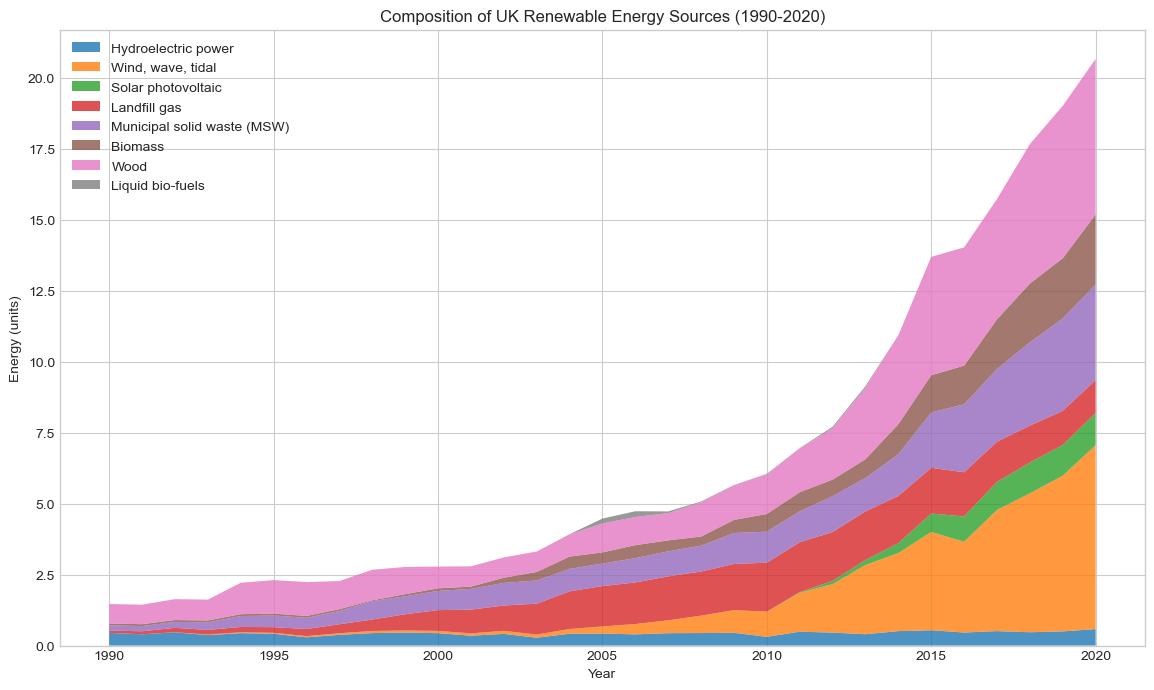

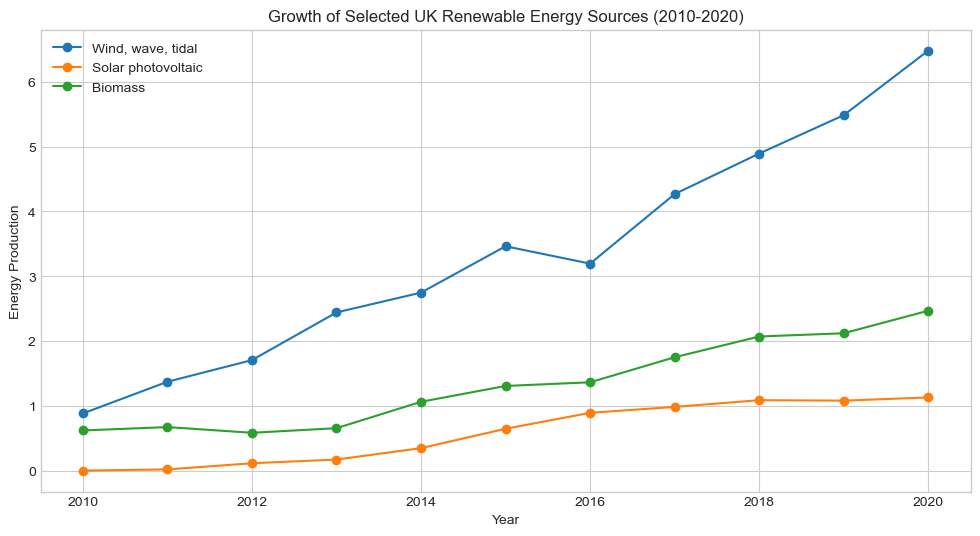

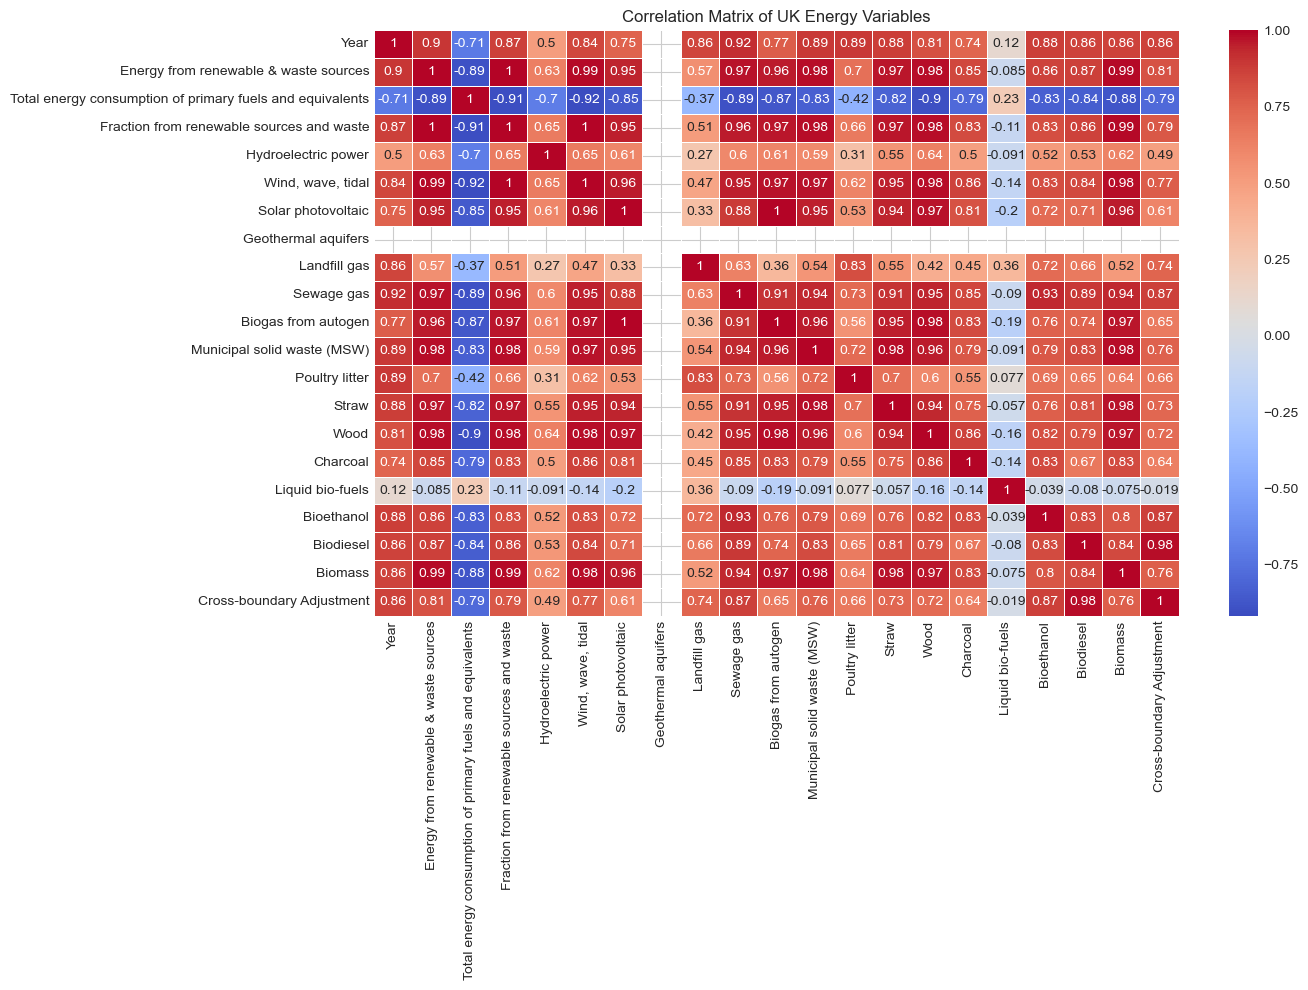

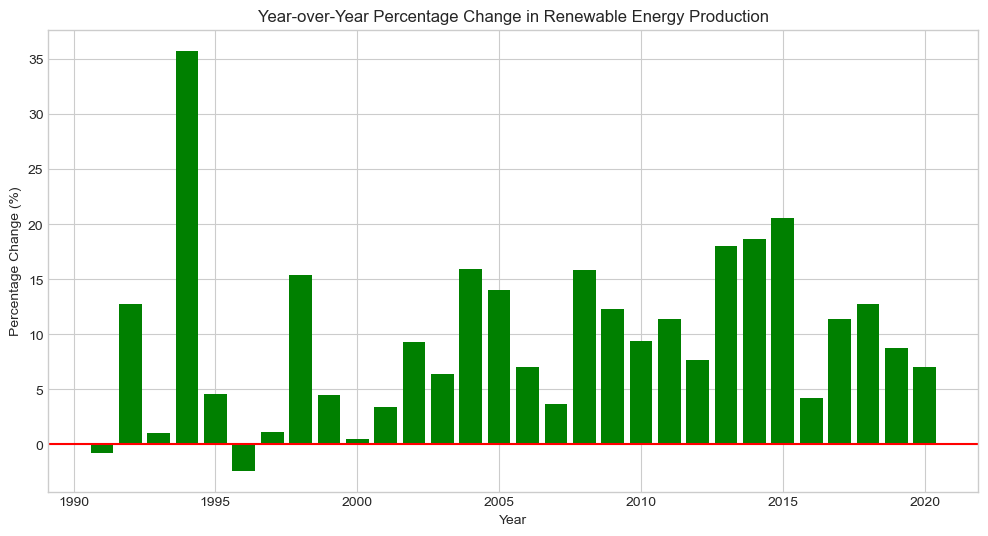


Step 3: Preparing features for modeling...
Shape after feature engineering: (28, 36)

Step 4: Building prediction models...

--- Building prediction models for Energy from renewable & waste sources ---
Feature ranges:
                                                            min          max
Total energy consumption of primary fuels and e...   169.439000   252.807000
Hydroelectric power                                    0.278000     0.580000
Geothermal aquifers                                    0.001000     0.001000
Landfill gas                                           0.162000     1.758000
Sewage gas                                             0.158000     0.440000
Biogas from autogen                                    0.000000     1.021000
Municipal solid waste (MSW)                            0.268000     3.367000
Poultry litter                                         0.043000     0.227000
Straw                                                  0.007000     0.338000
Wood       

Linear Regression - MSE: 0.0672, R²: -1.4825
Random Forest - MSE: 0.5897, R²: -20.7997

Step 5: Performing time series forecasting...


C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Predi


ARIMA Model Summary for Energy from renewable & waste sources:
                                         SARIMAX Results                                         
Dep. Variable:     Energy from renewable & waste sources   No. Observations:                   31
Model:                                    ARIMA(1, 1, 1)   Log Likelihood                 -23.124
Date:                                   Fri, 28 Feb 2025   AIC                             52.249
Time:                                           21:55:34   BIC                             56.452
Sample:                                                0   HQIC                            53.593
                                                    - 31                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

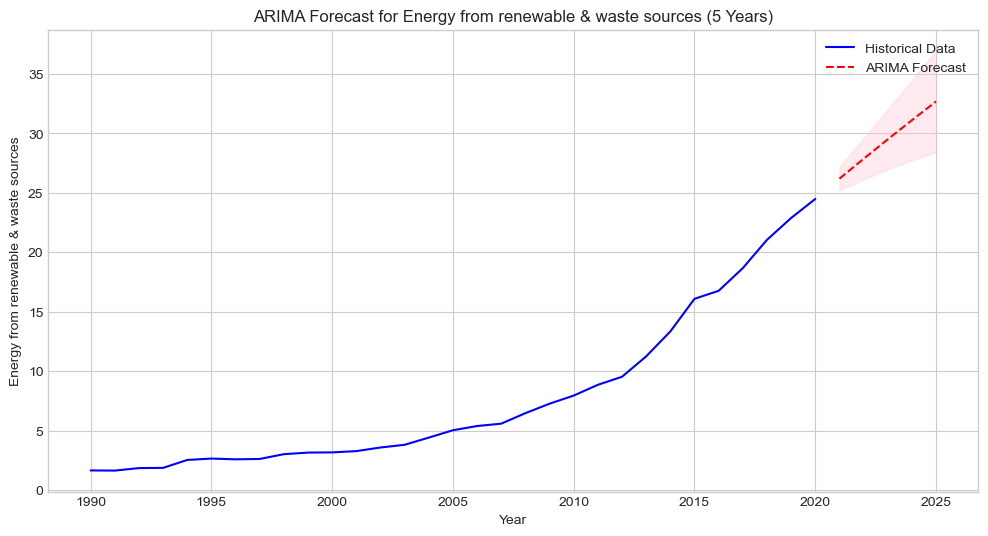

C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\karan\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed t


ARIMA Model Summary for Fraction from renewable sources and waste:
                                           SARIMAX Results                                           
Dep. Variable:     Fraction from renewable sources and waste   No. Observations:                   31
Model:                                        ARIMA(1, 1, 1)   Log Likelihood                 120.197
Date:                                       Fri, 28 Feb 2025   AIC                           -234.394
Time:                                               21:55:35   BIC                           -230.191
Sample:                                                    0   HQIC                          -233.050
                                                        - 31                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

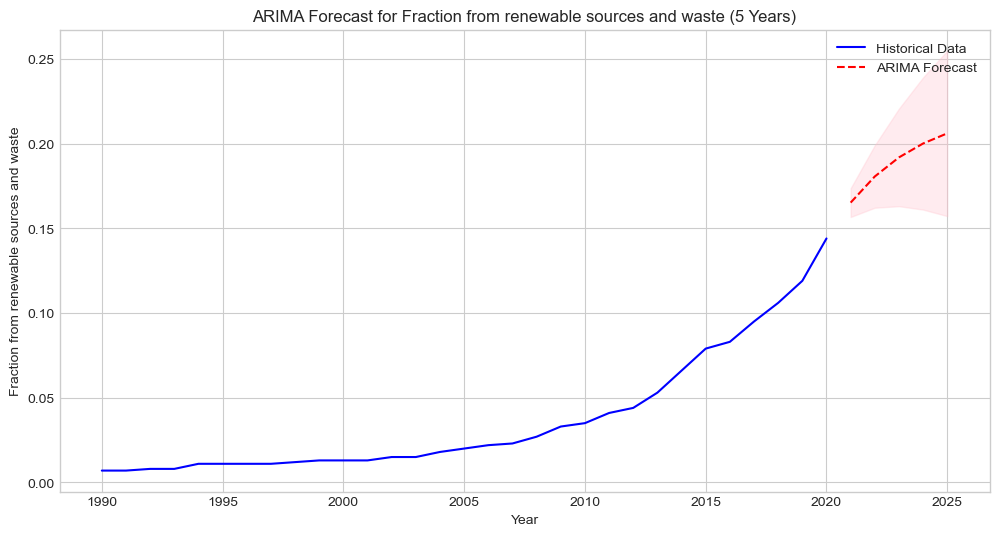


Step 6: Analyzing feature importance...

Top 10 Important Features for Energy from renewable & waste sources:
Wood: 0.1236
Total energy consumption of primary fuels and equivalents: 0.0952
Sewage gas: 0.0710
Cross-boundary Adjustment: 0.0649
Biomass: 0.0645
Years_Since_1990: 0.0580
Biogas from autogen: 0.0508
Liquid bio-fuels: 0.0455
Fraction_Renewable_Lag_2: 0.0448
Fraction_3yr_Rolling_Mean: 0.0441

Top 10 Important Features for Fraction from renewable sources and waste:
Total energy consumption of primary fuels and equivalents: 0.1699
Bioethanol: 0.0720
Fraction_Renewable_Lag_3: 0.0507
Fraction_3yr_Rolling_Mean: 0.0488
Fraction_Renewable_Lag_1: 0.0479
Biomass: 0.0451
Sewage gas: 0.0442
Fraction_Renewable_Lag_2: 0.0421
Years_Since_1990: 0.0417
Total_Renewable_Lag_1: 0.0399

Top 10 Important Features for Wind, wave, tidal:
Total energy consumption of primary fuels and equivalents: 0.1255
Wood: 0.1148
Bioethanol: 0.0720
Biogas from autogen: 0.0572
Fraction_Renewable_Lag_1: 0.0564
Years

In [49]:
if __name__ == "__main__":
    main()